In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import seaborn as sns
import random
from sklearn import model_selection
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.manifold import spectral_embedding
from sklearn.metrics import silhouette_score
from scipy import linalg
from scipy.sparse.csgraph import laplacian
from scipy.spatial import distance
from tslearn.metrics import cdist_dtw

# Get rid of some "wrong" errors
# check https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas for why
pd.options.mode.chained_assignment = None  # default='warn'

In [2]:
# Load data
DATA_DIR = 'data' # You may change the directory

users = pd.read_csv('{}/calcularis_small_users.csv'.format(DATA_DIR))
events = pd.read_csv('{}/calcularis_small_events.csv'.format(DATA_DIR))
subtasks = pd.read_csv('{}/calcularis_small_subtasks.csv'.format(DATA_DIR), index_col=0)

In [3]:
# extract game_name and number_range from the events dataframe to match the subtasks dataframe (given the event_id)
game_name = subtasks.merge(events[['event_id', 'game_name']], on='event_id', how='left').game_name
number_range = subtasks.merge(events[['event_id', 'number_range']], on='event_id', how='left').number_range

#split the game_name into skills
skill = game_name.apply(lambda x: 'Number representation'
                        if x in ['Subitizing', 'Conversion', 'Estimation', 'Estimation on Number Line', 'Scale: Conversion', 'Landing']
                        else 'Number comparison/manipulation' if x in ['Comparison', 'Secret Number', 'Distance', 'Scale: Composition', 'Order']
                        else 'Addition/Substraction' if x in ['Scale: Decomposition', 'Scale: Subtraction', 'Scale: Subtraction by Tens and Ones', 'Sliderule', 'Plus-minus', 'Difference', 'Completion', 'Calculator']
                        else 'Multiplication/Division' if x in ['Write as multiplication', 'Shelf: Jump Ahead', 'Shelf: given height', 'Shelf: random height', 'Distribution', 'Calculator: Multiplication', 'Calculator: Multiplication with ?', 'Calculator: Division', 'Jump backwards', 'Series']
                        else 'Other')

# concatenate skills and number range and add it to the subtasks dataframe
subtasks['skill_name'] = skill + ' ' + number_range
subtasks

,event_id,user_id,aim,answer,answerMode,availableNumbers,correct,correctAnswerObject,correctNumber,destination,...,subtask_finished_timestamp,target,timeoutInSeconds,timeoutInSteps,type,upperBound,divisor,orderIndependent,step,skill_name
subtask_id,,,,,,,,,,,,,,,,,,,,,
0,0,1,NaN,4,NaN,NaN,True,4,4.0,NaN,...,2022-11-02T08:39:24.930Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
1,0,1,NaN,1,NaN,NaN,True,NaN,NaN,NaN,...,2022-11-02T08:39:24.930Z,NaN,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10
2,1,1,NaN,3,NaN,NaN,True,3,NaN,ARABIC,...,2022-11-11T10:26:49.007Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
3,2,1,NaN,5,NaN,NaN,True,5,NaN,EXPLODED_BEAM,...,2022-11-18T10:34:12.191Z,NaN,NaN,NaN,ConciseConversionTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
4,3,1,3.0,"{'a': 2, 'b': 2.0402703}",NaN,NaN,False,"{'a': 3, 'b': 3.0}",NaN,NaN,...,2022-11-25T10:32:56.805Z,NaN,NaN,NaN,ConciseLandingTaskDescription,3.5,NaN,NaN,NaN,Number representation R10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55042,37415,998,46.0,"{'a': 47, 'b': 47.33128}",NaN,NaN,True,"{'a': 46, 'b': 46.0}",NaN,NaN,...,2021-01-06T14:14:46.133Z,NaN,NaN,NaN,ConciseLandingTaskDescription,50.0,NaN,NaN,NaN,Number representation R100
55043,37417,1000,NaN,1,NaN,NaN,False,3,3.0,NaN,...,2019-09-30T10:04:58.024Z,NaN,NaN,NaN,ConciseSubitizingTaskDescription,NaN,NaN,NaN,NaN,Number representation R10
55044,37417,1000,NaN,2,NaN,NaN,True,NaN,NaN,NaN,...,2019-09-30T10:04:58.024Z,NaN,0.0,2.0,ConciseTimeoutDescription,NaN,NaN,NaN,NaN,Number representation R10


# DKT model

In [4]:
from sklearn import feature_extraction, model_selection
from sklearn.model_selection import train_test_split
import tensorflow as tf

2023-05-23 11:05:38.403539: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-05-23 11:05:38.403594: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
# Useful functions for what comes next
def create_iterator(data):
    '''
    Create an iterator to split interactions in data into train and test, with the same student not appearing in two diverse folds.
    :param data:        Dataframe with student's interactions.
    :return:            An iterator.
    '''
    # Both passing a matrix with the raw data or just an array of indexes works
    X = np.arange(len(data.index))
    # Groups of interactions are identified by the user id (we do not want the same user appearing in two folds)
    groups = data['user_id'].values
    return model_selection.GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=0).split(X, groups=groups)

def prepare_seq(df):
    # Step 1 - Enumerate skill id, each different skill has a different id
    df['skill'], skill_codes = pd.factorize(df['skill_name'], sort=True)
    # Step 2 - Cross skill id with answer to form a synthetic feature, being 2*skill_id + correct, which is 1 if subtask was correct, 0 else
    df['skill_with_answer'] = df['skill'] * 2 + df['correct']
    # Step 3 - Convert to a sequence per user id and shift features 1 timestep, take all skill_with_answer except last value, take all skill and correct values except first
    seq = df.groupby('user_id').apply(lambda r: (r['skill_with_answer'].values[:-1], r['skill'].values[1:], r['correct'].values[1:],))

    # Step 4 - Get max skill depth and max feature depth
    skill_depth = df['skill'].max()+1
    features_depth = df['skill_with_answer'].max() + 1

    return seq, features_depth, skill_depth, skill_codes

def prepare_data(seq, params, features_depth, skill_depth):

    # Step 1 - Transform sequence to Tensorflow Dataset
    dataset = tf.data.Dataset.from_generator(generator=lambda: seq, output_types=(tf.int32, tf.int32, tf.float32))

    # Step 2 - Encode categorical features and merge skills with labels to compute target loss.
    dataset = dataset.map(
        lambda feat, skill, label: (
            tf.one_hot(feat, depth=features_depth),
            tf.concat(values=[tf.one_hot(skill, depth=skill_depth), tf.expand_dims(label, -1)], axis=-1)
        )
    )

    # Step 3 - Pad sequences per batch
    dataset = dataset.padded_batch(
        batch_size=params['batch_size'],
        padding_values=(params['mask_value'], params['mask_value']),
        padded_shapes=([None, None], [None, None]),
        drop_remainder=False
    )
    return dataset.repeat(), len(seq)

In [6]:
# Obtain indexes
train_index, test_index = next(create_iterator(subtasks))
# Split the data
X_train, X_test = subtasks.iloc[train_index], subtasks.iloc[test_index]

# Split train data in train and validation sets
# Obtain indexes for necessary validation set
train_val_index, val_index = next(create_iterator(X_train))
# Split the training data into training and validation
X_train_val, X_val = X_train.iloc[train_val_index], X_train.iloc[val_index]

In [7]:
# Specify parameters
params = {}
params['batch_size'] = 20
params['mask_value'] = -1.0

In [8]:
# Prepare the data
seq, features_depth, skill_depth, skill_codes = prepare_seq(subtasks)
seq_train = seq[X_train.user_id.unique()]
seq_val = seq[X_train_val.user_id.unique()]
seq_test = seq[X_test.user_id.unique()]

tf_train, length = prepare_data(seq_train, params, features_depth, skill_depth)
tf_val, val_length  = prepare_data(seq_val, params, features_depth, skill_depth)
tf_test, test_length = prepare_data(seq_test, params, features_depth, skill_depth)
full, full_length = prepare_data(seq, params, features_depth, skill_depth)

# Specify further params
params['train_size'] = int(length // params['batch_size'])
params['val_size'] = int(val_length // params['batch_size'])
params['test_size'] = int(test_length // params['batch_size'])

2023-05-23 11:05:41.004862: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-05-23 11:05:41.004938: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-05-23 11:05:41.004974: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (noto.epfl.ch): /proc/driver/nvidia/version does not exist
2023-05-23 11:05:41.005575: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Define model parameters
params['verbose'] = 1 # Verbose = {0,1,2}
params['best_model_weights'] = 'weights/bestmodel' # File to save the model
params['optimizer'] = 'adam' # Optimizer to use
params['backbone_nn'] = tf.keras.layers.RNN # Backbone neural network
params['recurrent_units'] = 16 # Number of RNN units
params['epochs'] = 10  # Number of epochs to train
params['dropout_rate'] = 0.3 # Dropout rate

In [10]:
# Function that removes predictions on time step associated with padding, and match outputs to specific skills
def get_target(y_true, y_pred, mask_value=params['mask_value']):

    # Get skills and labels from y_true
    mask = 1. - tf.cast(tf.equal(y_true, mask_value), y_true.dtype)
    y_true = y_true * mask

    skills, y_true = tf.split(y_true, num_or_size_splits=[-1, 1], axis=-1)

    # Get predictions for each skill
    y_pred = tf.reduce_sum(y_pred * skills, axis=-1, keepdims=True)

    return y_true, y_pred

In [11]:
# Define the metrics
class AUC(tf.keras.metrics.AUC):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(AUC, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

class RMSE(tf.keras.metrics.RootMeanSquaredError):
    def update_state(self, y_true, y_pred, sample_weight=None):
        true, pred = get_target(y_true, y_pred)
        super(RMSE, self).update_state(y_true=true, y_pred=pred, sample_weight=sample_weight)

def CustomBinaryCrossEntropy(y_true, y_pred):
    y_true, y_pred = get_target(y_true, y_pred)
    return tf.keras.losses.binary_crossentropy(y_true, y_pred)

In [12]:
# Model creation
def create_model(nb_features, nb_skills, params):

    # Create the model architecture
    inputs = tf.keras.Input(shape=(None, nb_features), name='inputs')
    x = tf.keras.layers.Masking(mask_value=params['mask_value'], name = 'masking')(inputs)
    x = tf.keras.layers.LSTM(params['recurrent_units'], return_sequences=True, dropout=params['dropout_rate'], name = 'lstm_layer')(x)
    dense = tf.keras.layers.Dense(nb_skills, activation='sigmoid')
    outputs = tf.keras.layers.TimeDistributed(dense, name='outputs')(x)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs, name='DKT')

    # Compile the model
    model.compile(loss=CustomBinaryCrossEntropy,
                  optimizer=params['optimizer'],
                  metrics=[AUC(), RMSE()])

    return model

model = create_model(features_depth, skill_depth, params)

In [13]:
model.summary()

Model: "DKT"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, None, 32)]        0         
                                                                 
 masking (Masking)           (None, None, 32)          0         
                                                                 
 lstm_layer (LSTM)           (None, None, 16)          3136      
                                                                 
 outputs (TimeDistributed)   (None, None, 16)          272       
                                                                 
Total params: 3,408
Trainable params: 3,408
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Model fit
ckp_callback = tf.keras.callbacks.ModelCheckpoint(params['best_model_weights'], save_best_only=True, save_weights_only=True)
history = model.fit(tf_train, epochs=params['epochs'], steps_per_epoch=params['train_size'],
                    validation_data=tf_val,  validation_steps = params['val_size'],
                    callbacks=[ckp_callback], verbose=params['verbose'])

# Model evaluation
model.load_weights(params['best_model_weights'])
metrics_dkt_small = model.evaluate(tf_test, verbose=params['verbose'], steps = params['test_size'])

Epoch 1/10
37/37 [==============================] - 28s 611ms/step - loss: 0.1626 - auc: 0.5887 - root_mean_squared_error: 0.4793 - val_loss: 0.1472 - val_auc: 0.6397 - val_root_mean_squared_error: 0.4483
Epoch 2/10
37/37 [==============================] - 21s 561ms/step - loss: 0.1333 - auc: 0.6282 - root_mean_squared_error: 0.4188 - val_loss: 0.1194 - val_auc: 0.6613 - val_root_mean_squared_error: 0.3913
Epoch 3/10
37/37 [==============================] - 21s 574ms/step - loss: 0.1174 - auc: 0.6656 - root_mean_squared_error: 0.3862 - val_loss: 0.1136 - val_auc: 0.6842 - val_root_mean_squared_error: 0.3813
Epoch 4/10
37/37 [==============================] - 20s 547ms/step - loss: 0.1143 - auc: 0.6808 - root_mean_squared_error: 0.3808 - val_loss: 0.1121 - val_auc: 0.6910 - val_root_mean_squared_error: 0.3787
Epoch 5/10
37/37 [==============================] - 20s 534ms/step - loss: 0.1133 - auc: 0.6863 - root_mean_squared_error: 0.3788 - val_loss: 0.1115 - val_auc: 0.6952 - val_root_me

In [15]:
# Getting the metrics
# Binary cross entropy, AUC, RMSE
print(metrics_dkt_small)
rmse_dkt = metrics_dkt_small[2]
auc_dkt = metrics_dkt_small[1]

[0.11844995617866516, 0.6972490549087524, 0.37318697571754456]


In [16]:
# Get index limits for the batches
indexes_limits = [0]
for i in range(len(seq_test.index.unique())//params['batch_size']) :
    indexes_limits.append(params['batch_size']*(i+1))
indexes_limits.append(test_length)

In [17]:
# Do the predictions batch-by-batch
model_predictions = []
for i in range(len(indexes_limits)-1) :
    curr_seq = seq_test[seq_test.index.unique().sort_values(ascending = True)[indexes_limits[i]:indexes_limits[i+1]]]
    curr_tf, curr_length  = prepare_data(curr_seq, params, features_depth, skill_depth)
    curr_prediction = model.predict(curr_tf, verbose = params['verbose'], steps = 1)
    model_predictions.append(curr_prediction)

1/1 [==============================] - 0s 68ms/step


In [18]:
# Define some useful functions for the apply operations that come next
def new_user_id(series, unique_ids) :
    for i in range(len(unique_ids)) :
        if(unique_ids[i] == series["user_id"]) :
            return i

def fetch_prediction(series, predictions) :
    timepoint_number = series["timepoint"]-1
    if(timepoint_number == -1) :
        return -999
    else :
        batch_number = series["new_user_id"]//params["batch_size"]
        number_withinBatch = series["new_user_id"]%params["batch_size"]
        skill_code = series["skill_code"]
        return predictions[batch_number][number_withinBatch, timepoint_number, skill_code]

In [19]:
# Get a dataframe of interest
# The original features we are interested in are : user_id, skill_name, correct
proba_df = X_test[["user_id", "skill_name", "correct"]]

# Add a column to have a user_id that starts from 0 and doesn't skip any number, this will be removed later
unique_ids = proba_df["user_id"].unique()
proba_df["new_user_id"] = proba_df.apply(lambda x : new_user_id(x, unique_ids), axis = 1)

# Generate column with timepoint proba_df
proba_df["index_copy"] = proba_df.index
start_idxs = proba_df.groupby(by = "new_user_id").min()["index_copy"].values
proba_df["timepoint"] = proba_df.apply(lambda x : x["index_copy"] - start_idxs[x["new_user_id"]], axis = 1)
proba_df

# Fetch the skill codes
skill_codes_dict = {}
for i in range(len(skill_codes)) :
        skill_codes_dict[skill_codes[i]] = i
proba_df["skill_code"] = proba_df.apply(lambda x : skill_codes_dict[x["skill_name"]], axis = 1)

In [20]:
# Fetch the prediction and add to dataframe
proba_df["correct_predictions"] = proba_df.apply(lambda x : fetch_prediction(x, model_predictions), axis = 1)

# Get rid of useless columns, rename the "correct" column to "y_true" and convert it to 0s and 1s
proba_df.drop(["new_user_id", "index_copy", "timepoint", "skill_code", "correct"], axis = 1, inplace = True)

# Get rid of the rows representing the first attempt, as there is no prediction on those
proba_df = proba_df[proba_df["correct_predictions"]!=-999]

# Add the attempt number
proba_df["attempt"] = proba_df.groupby(by = "user_id").cumcount().apply(lambda x : x+1)

In [21]:
# Define set of skills
skills = subtasks['skill_name'].unique()

# Make prediction dataset
proba_dataset = {}
proba_test = {}
for skill in skills:
    proba_dataset[skill] = proba_df[proba_df["skill_name"] == skill]
    proba_test[skill] = proba_df[proba_df["skill_name"] == skill]

    # Add the attempt number
    proba_dataset[skill]['attempt'] = proba_dataset[skill].groupby(by = "user_id").cumcount()
    proba_test[skill]['attempt'] = proba_test[skill].groupby(by = "user_id").cumcount()

    #remove students with too small number of attempts and troncate times series to have them of same length
    proba_dataset[skill].reset_index(inplace=True)                                                  
    min_attempt = proba_dataset[skill].groupby('user_id').size().mean()*1.2
    proba_dataset[skill] = proba_dataset[skill].groupby(['user_id']).filter(lambda x: len(x) > min_attempt)
    proba_dataset[skill] = proba_dataset[skill].groupby("user_id").head(min_attempt)

proba_dataset['Number representation R10']



,subtask_id,user_id,skill_name,correct_predictions,attempt
8,1550,29,Number representation R10,0.589307,0
9,1551,29,Number representation R10,0.619525,1
10,1552,29,Number representation R10,0.642304,2
11,1559,29,Number representation R10,0.631677,3
12,1560,29,Number representation R10,0.630974,4
...,...,...,...,...,...
807,55015,998,Number representation R10,0.619525,1
808,55016,998,Number representation R10,0.610184,2
809,55018,998,Number representation R10,0.613390,3
810,55019,998,Number representation R10,0.653586,4


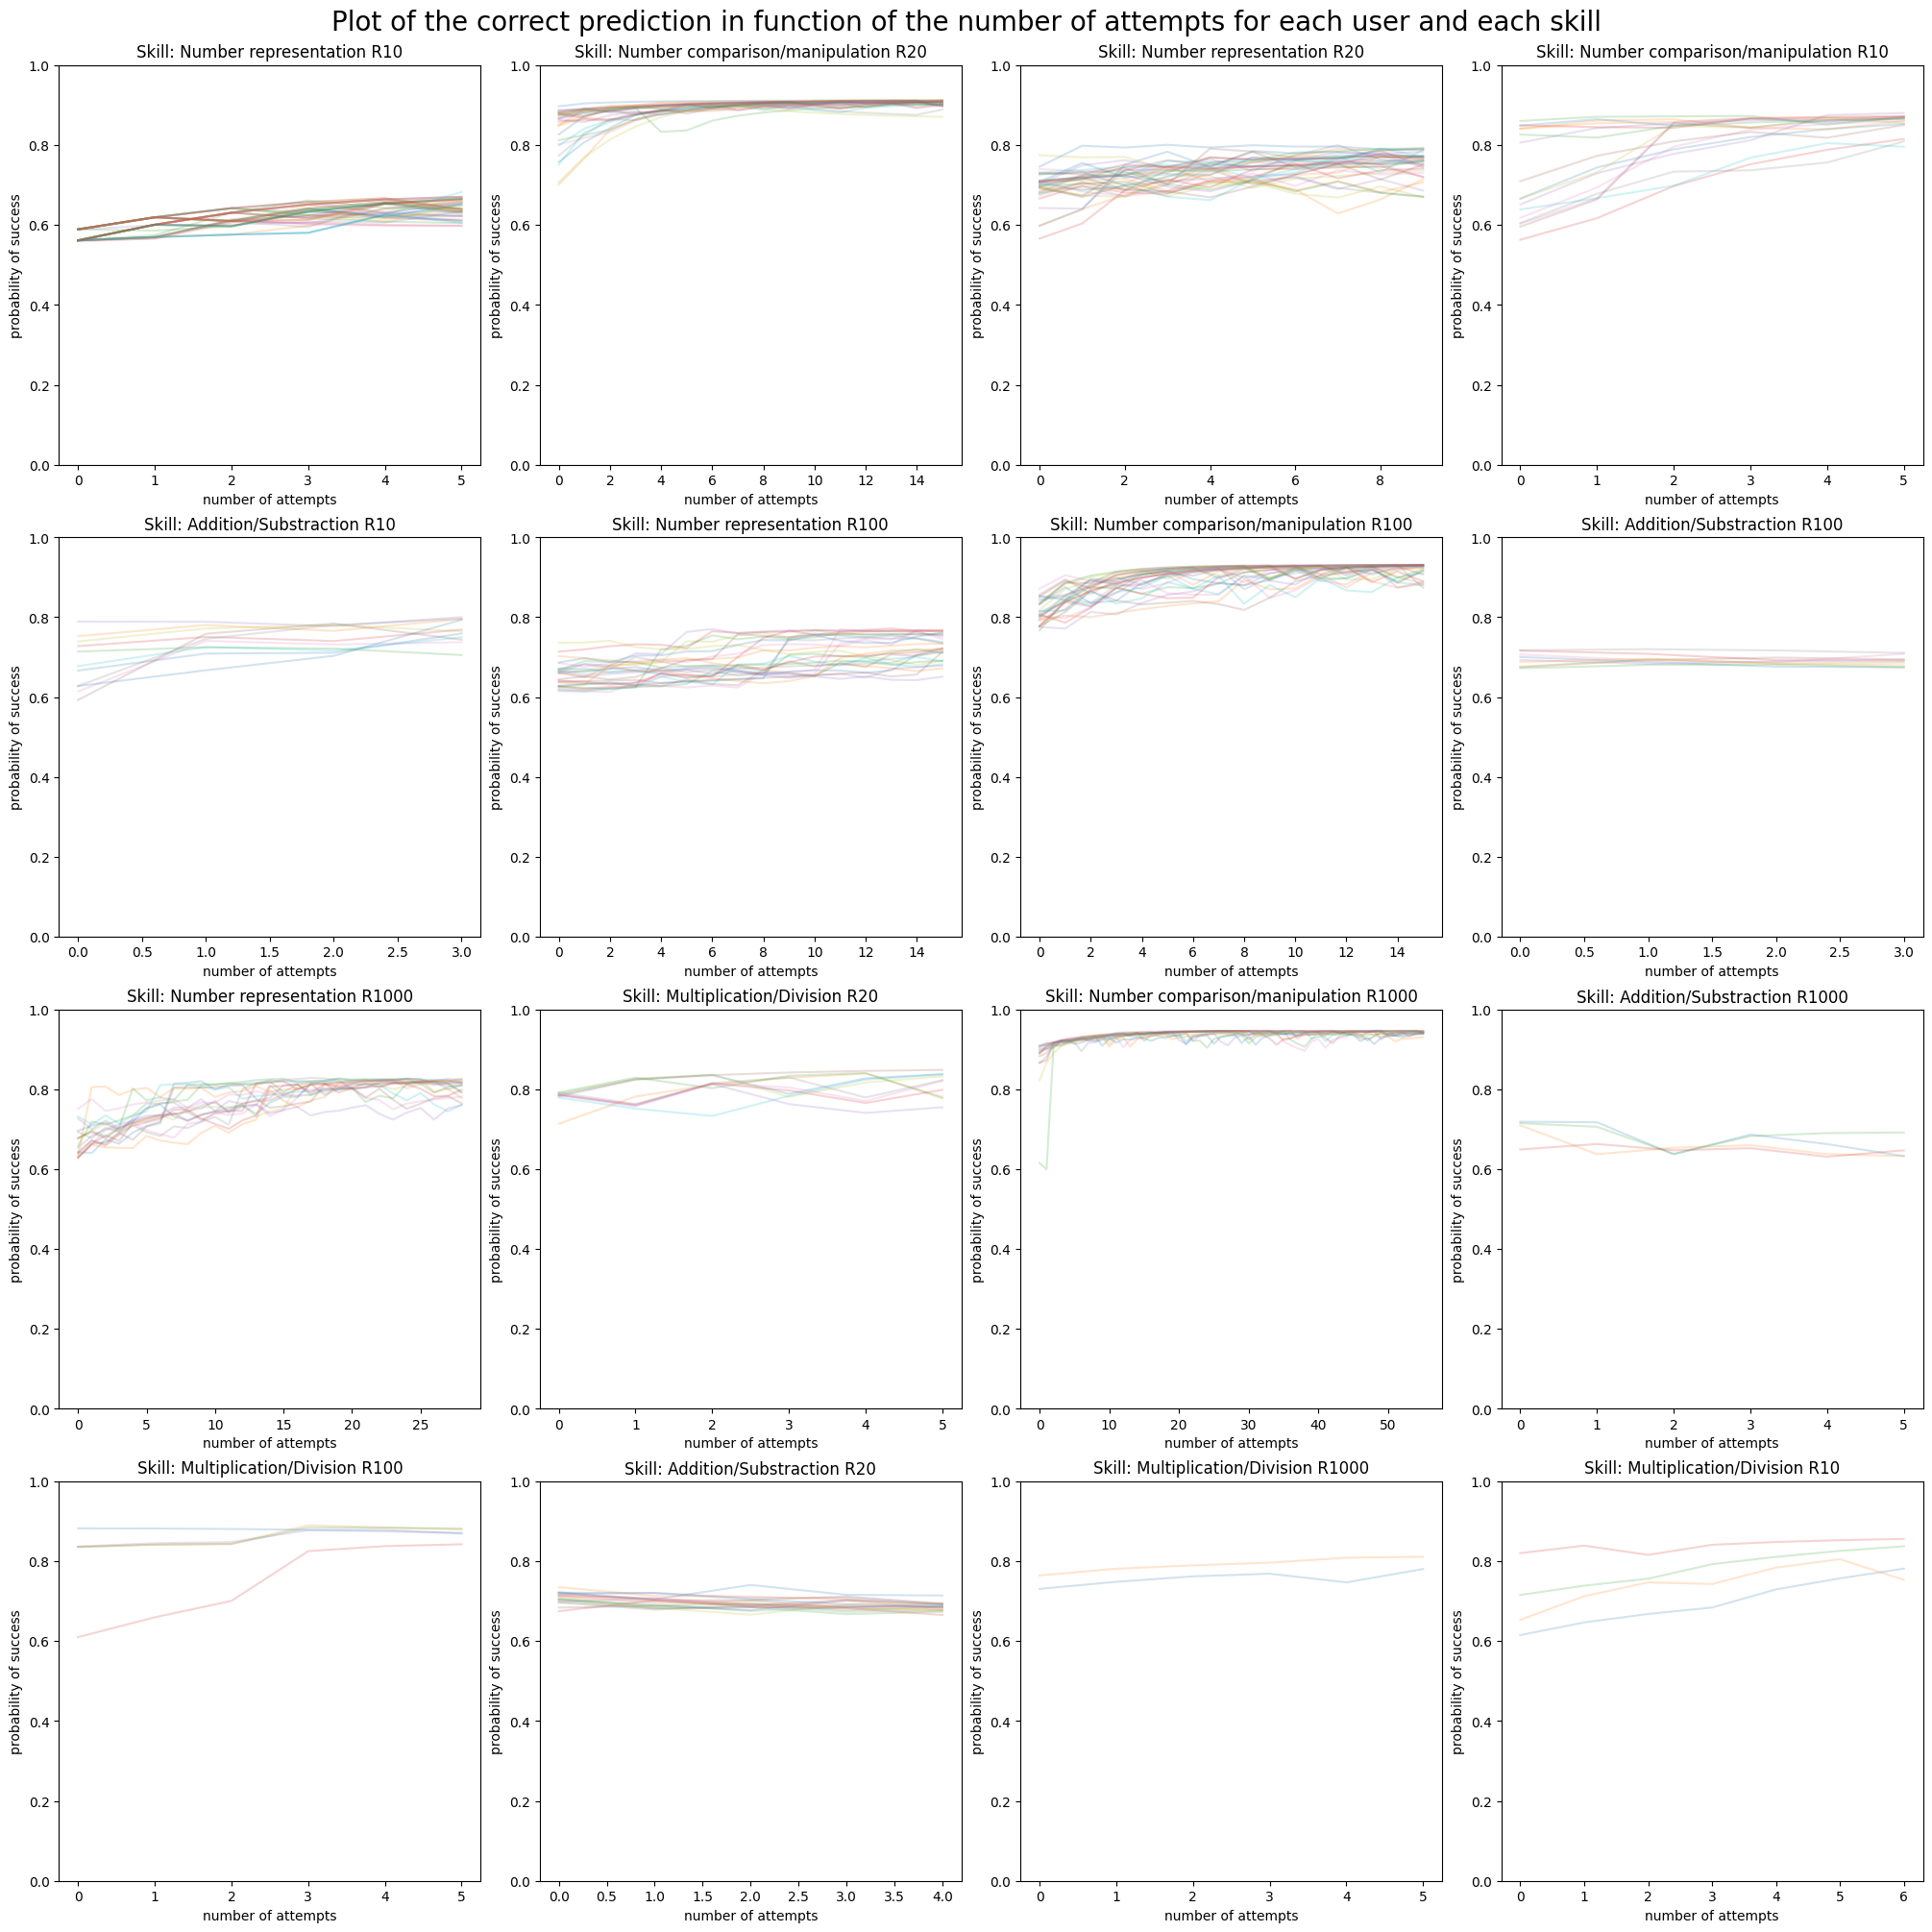

In [22]:
fig, ax = plt.subplots(4, 4, figsize=(20, 20), constrained_layout=True)
for skill, axe in zip(skills, ax.flatten()):
    df = proba_dataset[skill].set_index('attempt', inplace=False)
    df.groupby('user_id')['correct_predictions'].plot(alpha=0.2, ax=axe, legend=False)
    axe.set_xlabel('number of attempts')
    axe.set_ylabel('probability of success')
    axe.set_title('Skill: {}'.format(skill))
    axe.set_ylim(0, 1)
plt.suptitle('Plot of the correct prediction in function of the number of attempts for each user and each skill', fontsize=20)
plt.show()

# Clustering with Dynamic Time Warping

In [23]:
def get_time_series(df):
    """
    reshapes DataFrame from long to wide and returns an np.array
    :param df: pd.DataFrame with data in long format
    :return: np.array with reshaped data
    """
    display(df.user_id.nunique())
    df_array = (df.groupby('user_id').agg({'correct_predictions': lambda x: list(x)}))
    #display(df_array)

    #data = pd.DataFrame(df_array["correct_predictions"].values.tolist()).values
    return df_array

def get_adjacency(S, connectivity='full'):
    """
    Computes the adjacency matrix
    :param S: np array of similarity matrix
    :param connectivity: type of connectivity
    :return: adjacency matrix
    """

    if(connectivity=='full'):
        adjacency = S
    elif(connectivity=='epsilon'):
        epsilon = 0.5
        adjacency = np.where(S > epsilon, 1, 0)
    else:
        raise RuntimeError('Method not supported')

    return adjacency

def spectral_clustering(W, n_clusters, random_state=111):
    """
    Spectral clustering
    :param W: np array of adjacency matrix
    :param n_clusters: number of clusters
    :return: tuple (kmeans, proj_X, eigenvals_sorted)
        WHERE
        kmeans scikit learn clustering object
        proj_X is np array of transformed data points
        eigenvals_sorted is np array with ordered eigenvalues

    """
    # Compute eigengap heuristic
    L = laplacian(W, normed=True)  #Compute the unnormalized graph laplacian
    eigenvals, _ = linalg.eig(L)
    eigenvals = np.real(eigenvals)
    eigenvals_sorted = eigenvals[np.argsort(eigenvals)]

    # Create embedding
    random_state = np.random.RandomState(random_state)
    proj_X = spectral_embedding(W, n_components=n_clusters,
                              random_state=random_state,
                              drop_first=False)

    # Cluster the points using k-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state = random_state, n_init=10)
    kmeans.fit(proj_X)

    return kmeans, proj_X, eigenvals_sorted

def plot_metrics(n_clusters_list, metric_dictionary):
    """
    Plots metric dictionary (auxilary function)
    [Optional]

    :param n_clusters_list: List of number of clusters to explore
    :param metric_dictionary:
    """
    fig = plt.figure(figsize=(12, 10), dpi=80)
    i = 1

    for metric in metric_dictionary.keys():
        plt.subplot(3, 2, i)

        if metric == 'Eigengap':
            clusters = len(n_clusters_list)
            eigenvals_sorted = metric_dictionary[metric]
            plt.scatter(range(1, len(eigenvals_sorted[:clusters * 2]) + 1), eigenvals_sorted[:clusters * 2])
            plt.xlabel('Eigenvalues')
            plt.xticks(range(1, len(eigenvals_sorted[:clusters * 2]) + 1))
        else:
            plt.plot(n_clusters_list, metric_dictionary[metric], '-o')
            plt.xlabel('Number of clusters')
            plt.xticks(n_clusters_list)
        plt.ylabel(metric)
        i += 1
    plt.show()

def get_heuristics_spectral(W, n_clusters_list, plot=True):
    """
    Calculates heuristics for optimal number of clusters with Spectral Clustering

    :param W: np array of adjacency matrix
    :param n_clusters_list: List of number of clusters to explore
    :plot: bool, plot the metrics if true
    """
    silhouette_list = []
    eigengap_list = []

    df_labels = pd.DataFrame()

    for k in n_clusters_list:

        kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, k)
        y_pred = kmeans.labels_
        df_labels[str(k)] = y_pred

        if k == 1:
            silhouette = np.nan
        else:
            silhouette = silhouette_score(proj_X, y_pred)
        silhouette_list.append(silhouette)


    metric_dictionary = {
                         'Silhouette': silhouette_list,
                         'Eigengap': eigenvals_sorted,
                        }

    if(plot):
        plot_metrics(n_clusters_list, metric_dictionary)
        return df_labels
    else:
        return df_labels, metric_dictionary

def get_distance_matrix(X, metric='euclidean', window=2):
    """
    calculates distance matrix given a metric
    :param X: np.array with students' time-series
    :param metric: str distance metric to compute
    :param window: int for DTW
    :return: np.array with distance matrix
    """
    #norms = np.linalg.norm(X, axis=1)
    #data_normalized = X / norms[:, np.newaxis]

    data_normalized = X['correct_predictions'].apply(lambda x: [i/np.linalg.norm(x) for i in x]).values.tolist()

    if metric == 'dtw':
        distance_matrix = cdist_dtw(data_normalized,
                                    global_constraint='sakoe_chiba',
                                    sakoe_chiba_radius=window)
    else:
        distance_vector = distance.pdist(data_normalized, metric)
        distance_matrix = distance.squareform(distance_vector)
    return distance_matrix

def get_affinity_matrix(D, gamma=1):
    """
    calculates affinity matrix from distance matrix
    :param D: np.array distance matrix
    :param gamma: float coefficient for Gaussian Kernel
    :return:
    """
    S = np.exp(-gamma * D ** 2)
    return S

In [24]:
def skill_clustering(skill,proba_dataset,nb_groups,w,g):
    
    #get data in right format for clustering
    data = get_time_series(proba_dataset[skill])
    
    #Clustering
    D = get_distance_matrix(data, metric='dtw', window=0)
    S = get_affinity_matrix(D,gamma=g)
    W = get_adjacency(S)
    kmeans, proj_X, eigenvals_sorted = spectral_clustering(W, nb_groups)
    
    #get labels predictions
    y_pred = kmeans.labels_
    data["labels"]=y_pred
    
    return proba_dataset[skill].merge(data['labels'], on='user_id'),W

def clustering_vizualisation(skill,proba_dataset,nb_groups,window,gamma=1, title=''):
    
    proba_dataset[skill],W = skill_clustering(skill,proba_dataset,nb_groups,w,gamma)
    
    #Observe ideal number of clusters
    n_cluster_list = range(1, 10)
    df_labels = get_heuristics_spectral(W, n_cluster_list)   

    #Vizualize
    fig, axs = plt.subplots(1, nb_groups+1, figsize=(15, 5), sharex=True, sharey=True)
    sns.scatterplot(data=proba_dataset[skill], x = proba_dataset[skill].attempt, y = proba_dataset[skill].correct_predictions, hue='labels', alpha=0.2, s=8, ax=axs[0])
    for i in range(nb_groups) :
        df = proba_dataset[skill][proba_dataset[skill]['labels']==i]
        #sns.scatterplot(data=df, x = df.attempt, y = df.correct_predictions, alpha=0.2, s=8, ax=axs[i+1])

        grouped_df = df.groupby('user_id')
        for user_id, group in grouped_df:
            sns.lineplot(data=group, x='attempt', y='correct_predictions', alpha=0.2, ax=axs[i+1])

    for i in range(nb_groups+1):
        axs[i].set_xlabel('number of attempts')
        axs[i].set_ylabel('probability of success/having mastered the skill')
        axs[i].set_ylim(0, 1)
        axs[i].set_title(skill)
    fig.suptitle(title)
    
    plt.show()

    return proba_dataset[skill]

## Clustering vizualization to find parameters

27

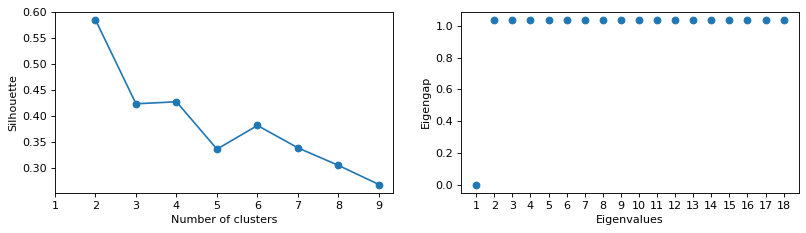

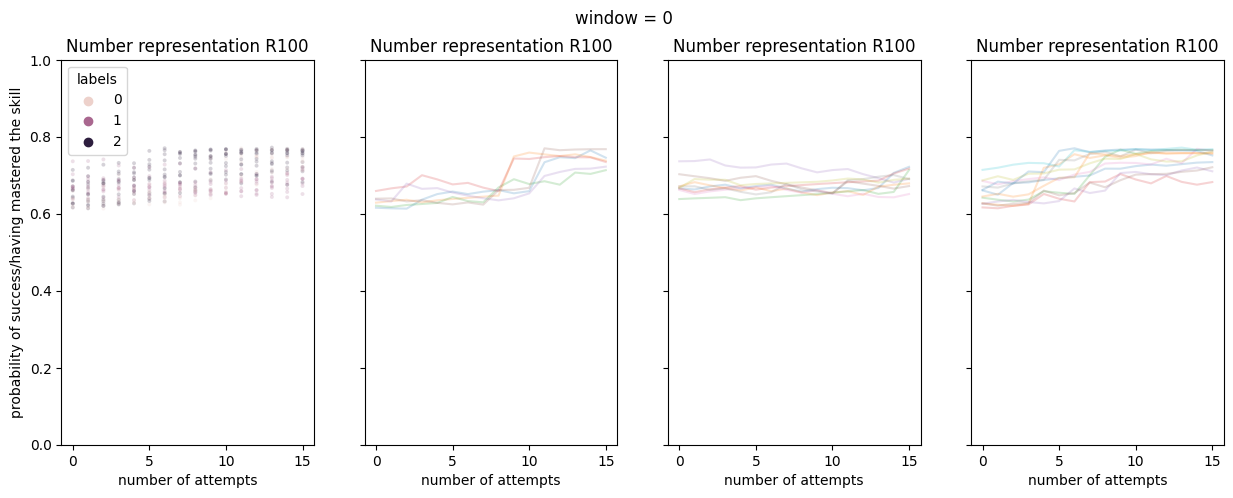

27

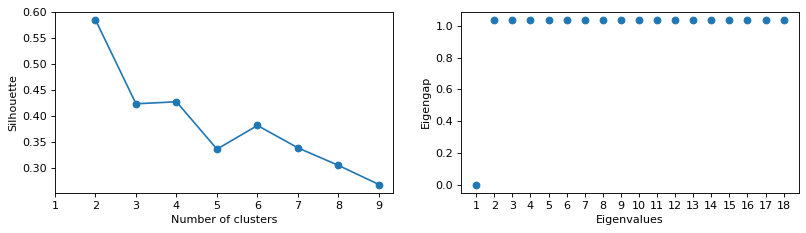

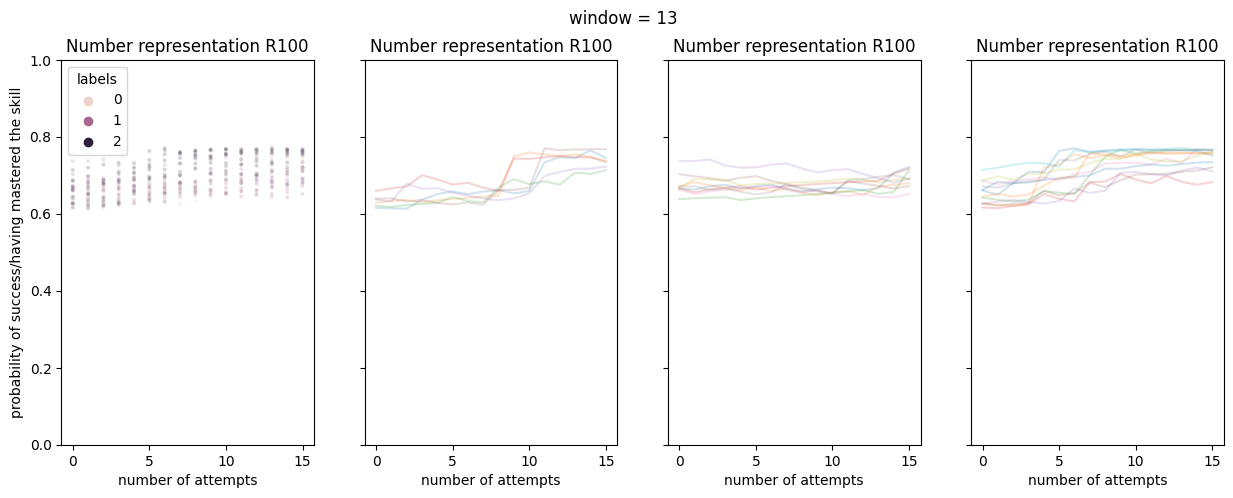

27

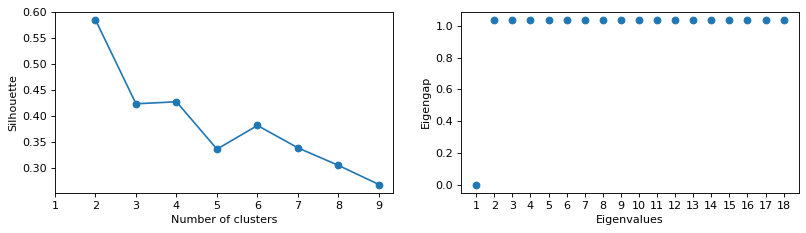

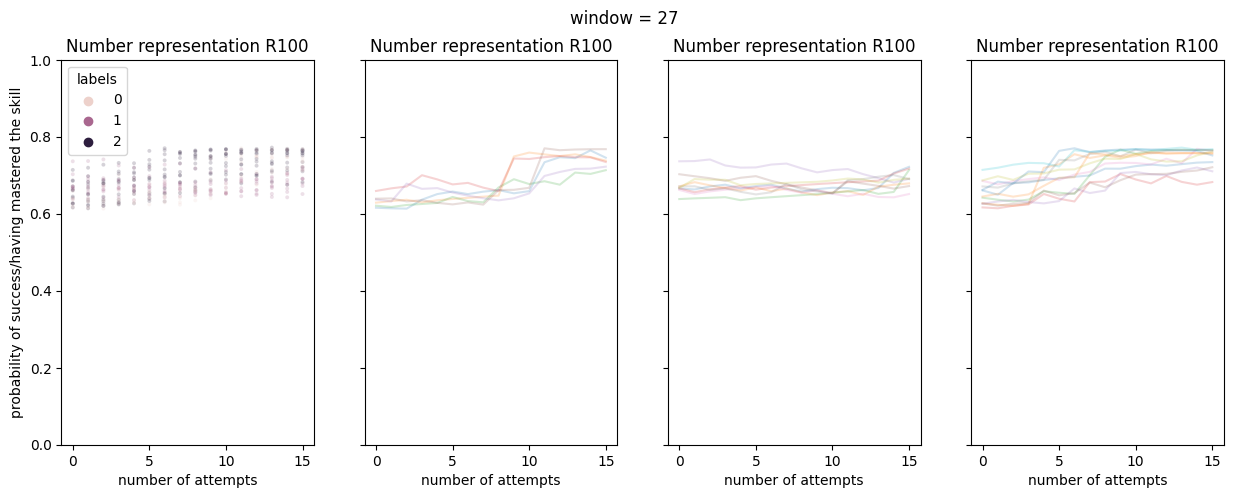

27

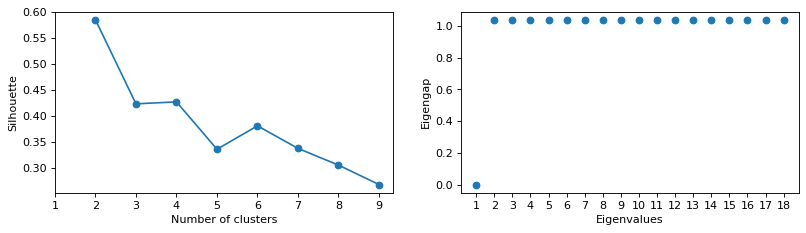

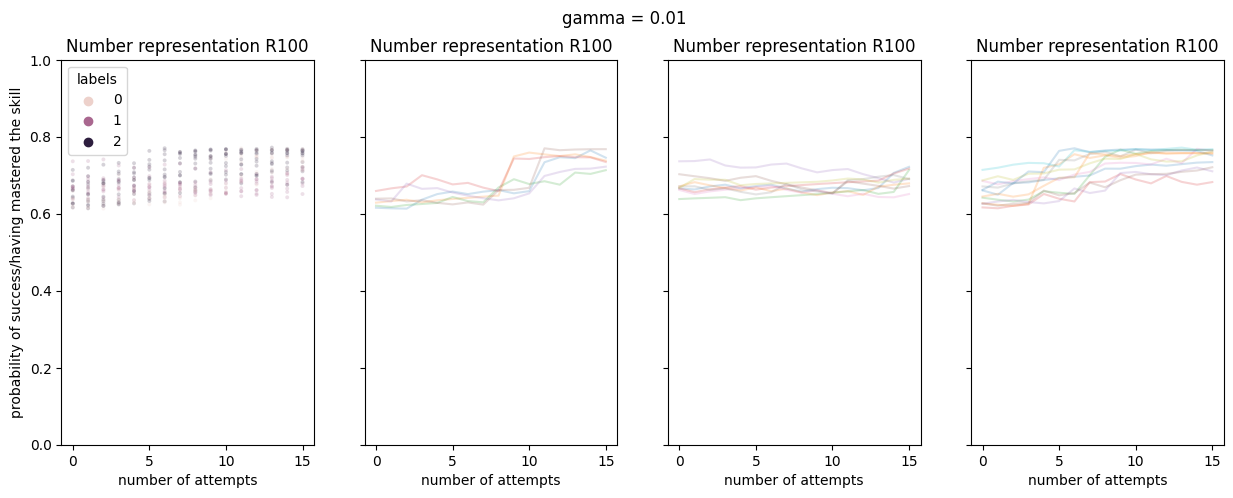

27

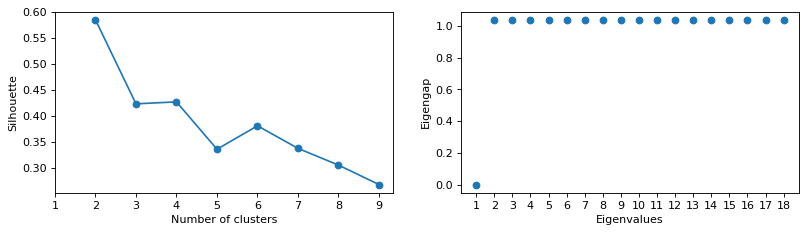

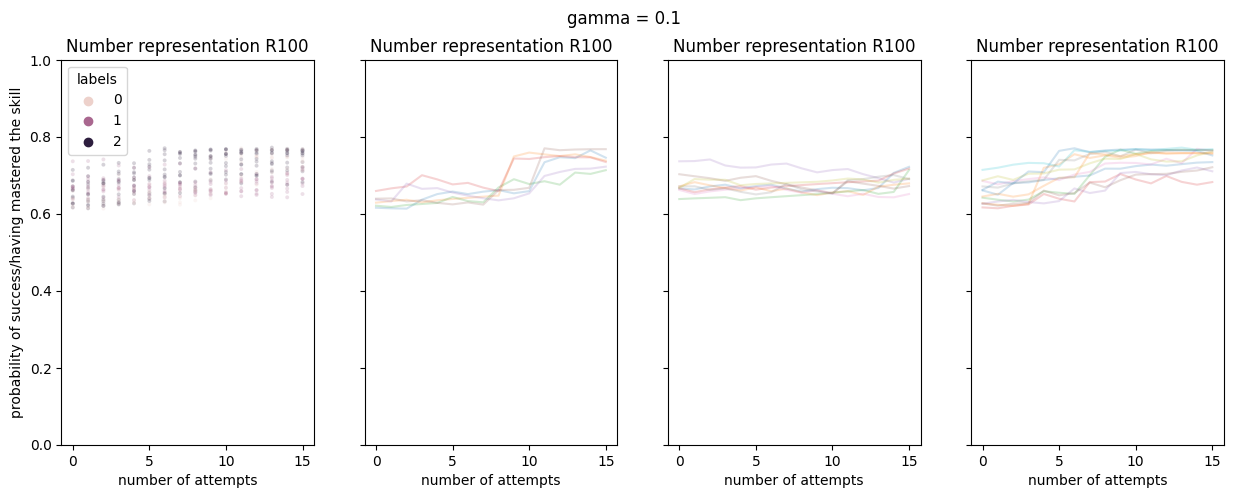

27

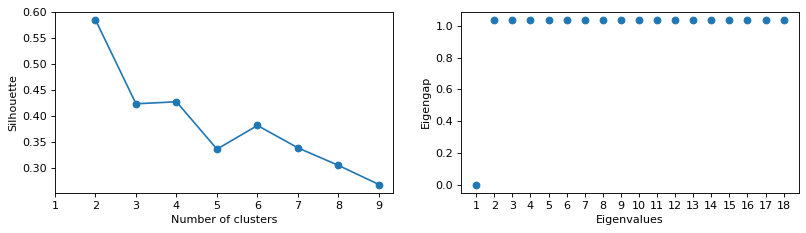

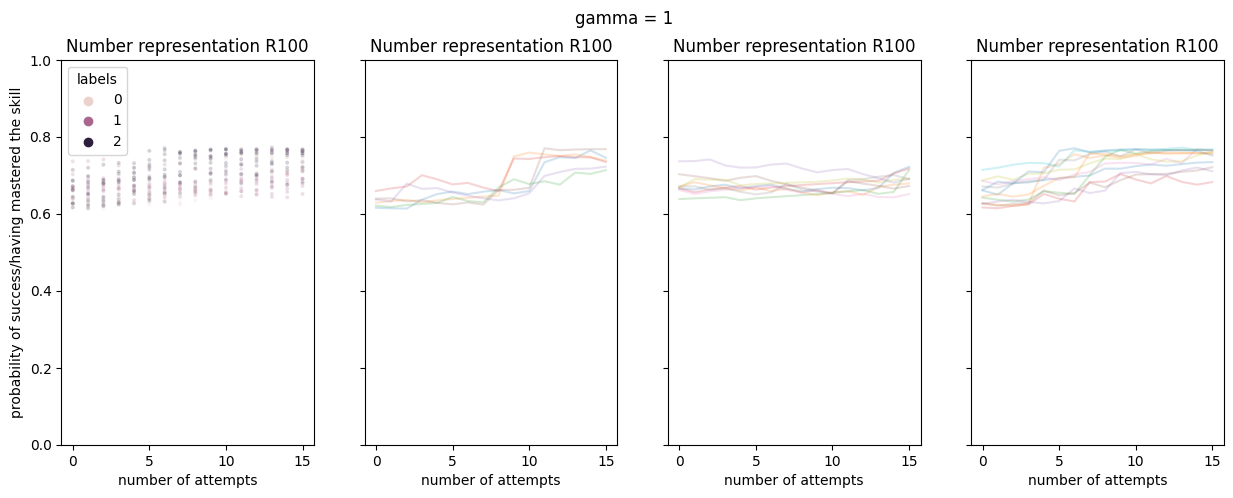

In [25]:
skill = "Number representation R100"
#data = get_time_series(proba_dataset[skill])
#data = data['correct_predictions'].values.tolist()

nb_users = proba_dataset[skill].user_id.nunique()
windows = [0,int(nb_users/2),nb_users]
gamma = [0.01,0.1,1]
nb_groups = 3

for w in windows:
    proba_dataset[skill] = clustering_vizualisation(skill,proba_dataset,nb_groups,w,title='window = '+str(w))
    proba_dataset[skill] = proba_dataset[skill].drop('labels', axis=1)

w=0
for g in gamma:
    proba_dataset[skill] = clustering_vizualisation(skill,proba_dataset,nb_groups,w,g, title='gamma = '+str(g))
    proba_dataset[skill] = proba_dataset[skill].drop('labels', axis=1)

## Remove skills with not enough data and attribute clusters' number to each

In [26]:
# Remove the skills with not enough data
min_students = 15
removed_skills = subtasks['skill_name'].unique()
skills = [skill for skill in skills if proba_dataset[skill]["user_id"].nunique() > min_students]
removed_skills = [skill for skill in removed_skills if skill not in skills]
print('The skills that are removed are:', *removed_skills, sep=', ')
print('Remaining skills are:', *skills, sep=', ')

#Attribute clusters' number
nb_clusters = {"Number representation R10" : 1, "Number comparison/manipulation R20" : 2, "Number representation R20" : 2,
               "Number comparison/manipulation R10" : 2, "Number representation R100" : 3, "Number comparison/manipulation R100" : 2, "Number representation R1000" : 1, "Addition/Substraction R20" : 1}



The skills that are removed are:, Addition/Substraction R10, Addition/Substraction R100, Multiplication/Division R20, Number comparison/manipulation R1000, Addition/Substraction R1000, Multiplication/Division R100, Multiplication/Division R1000, Multiplication/Division R10
Remaining skills are:, Number representation R10, Number comparison/manipulation R20, Number representation R20, Number comparison/manipulation R10, Number representation R100, Number comparison/manipulation R100, Number representation R1000, Addition/Substraction R20


## Clustering on each skill

44

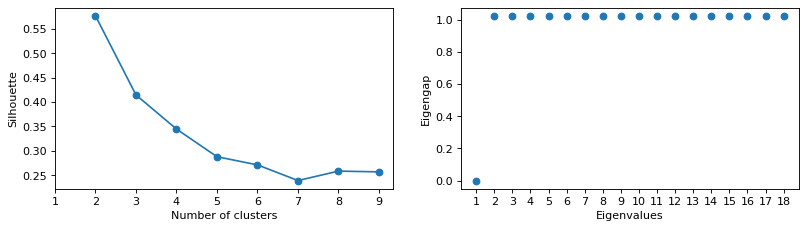

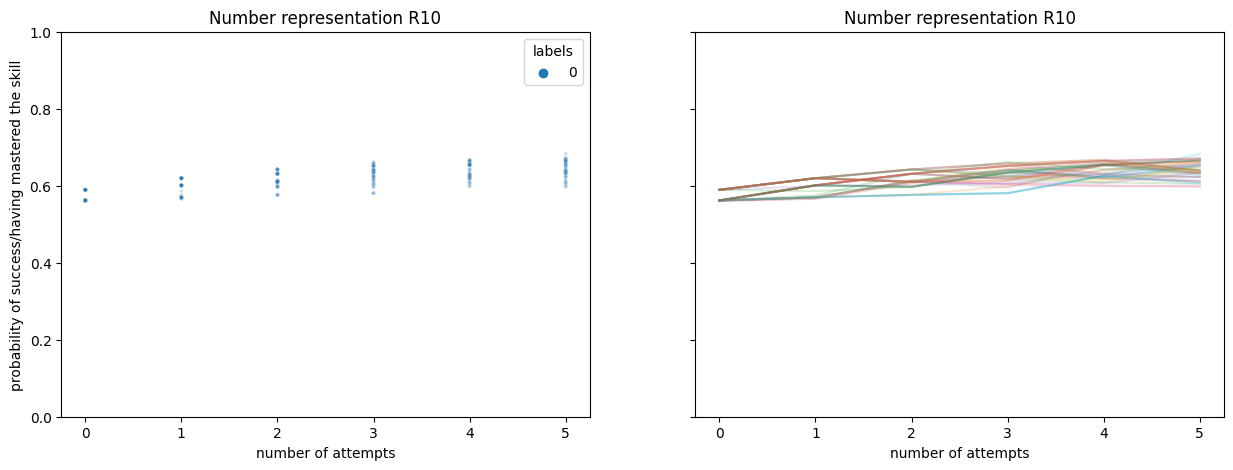

29

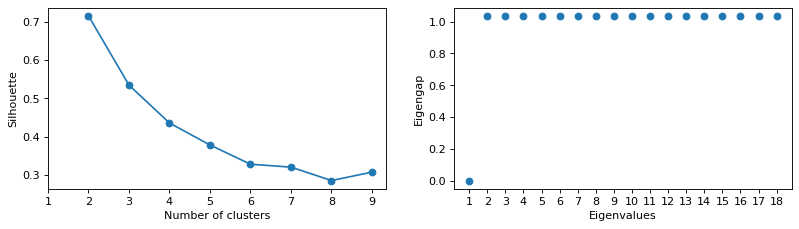

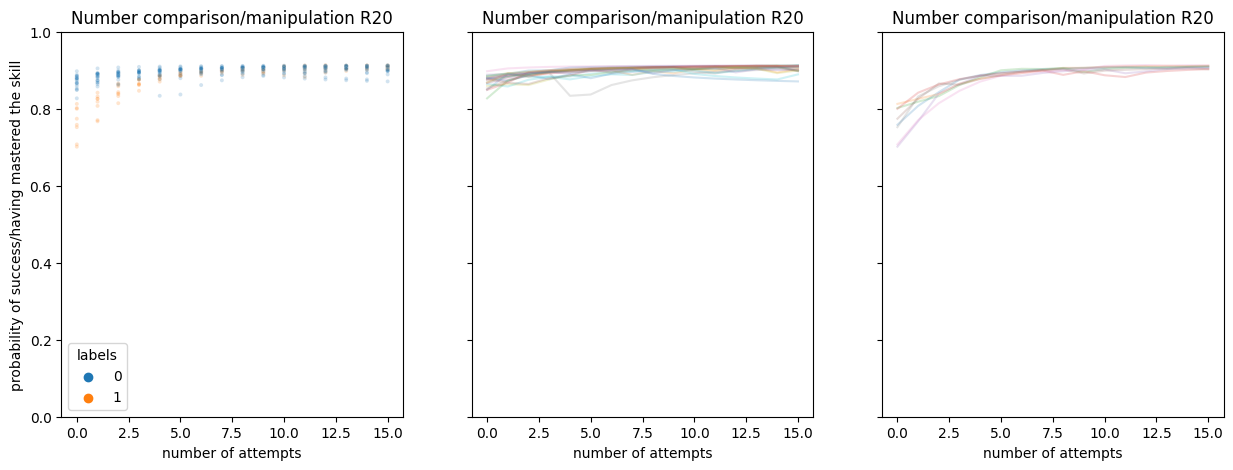

36

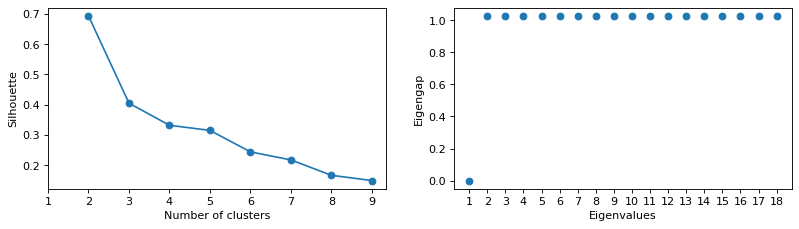

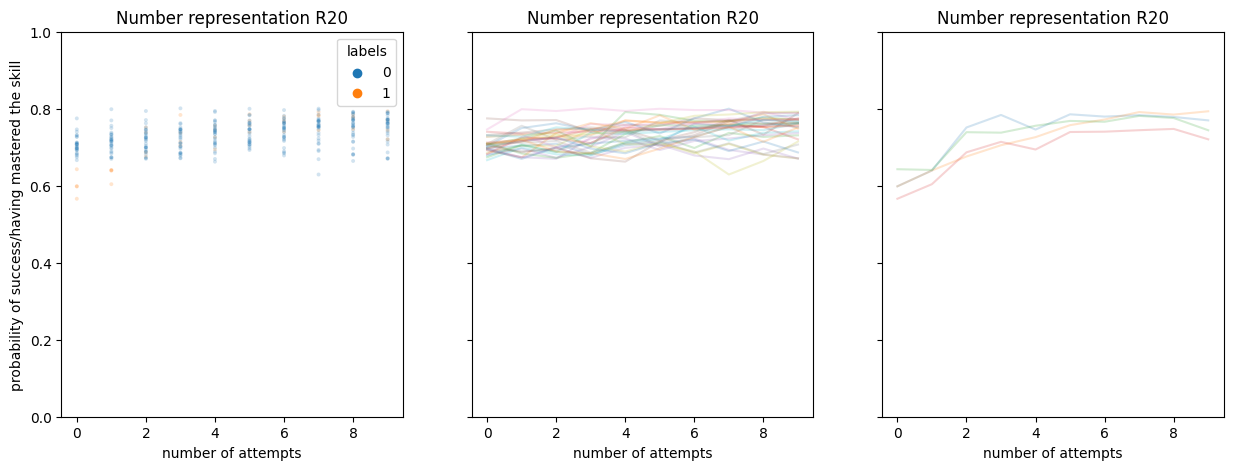

17

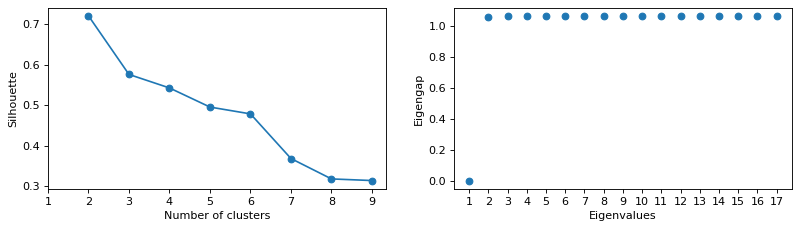

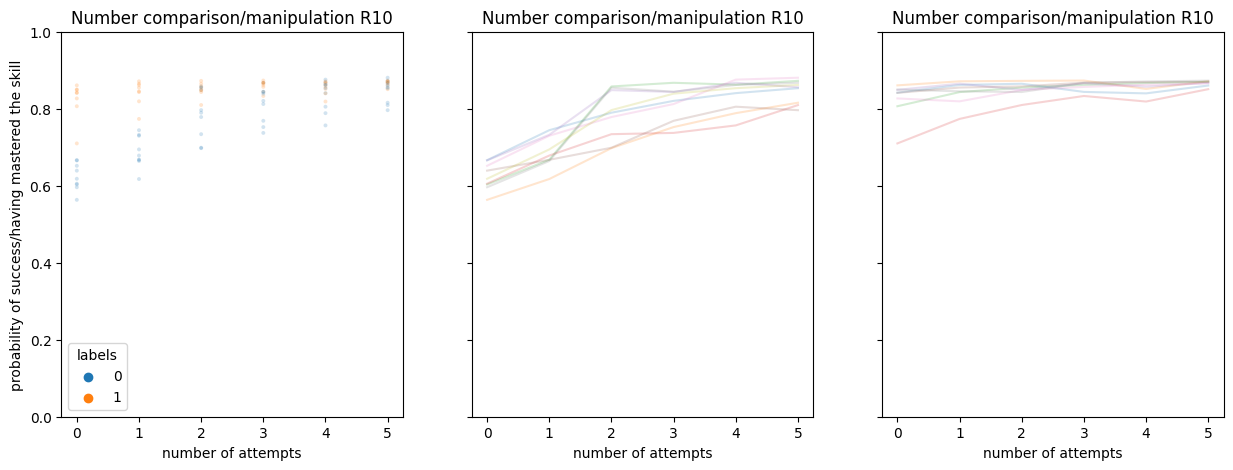

27

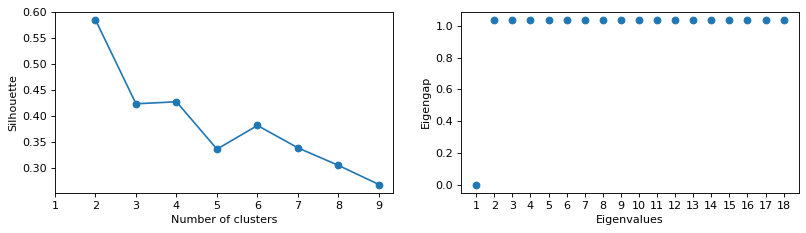

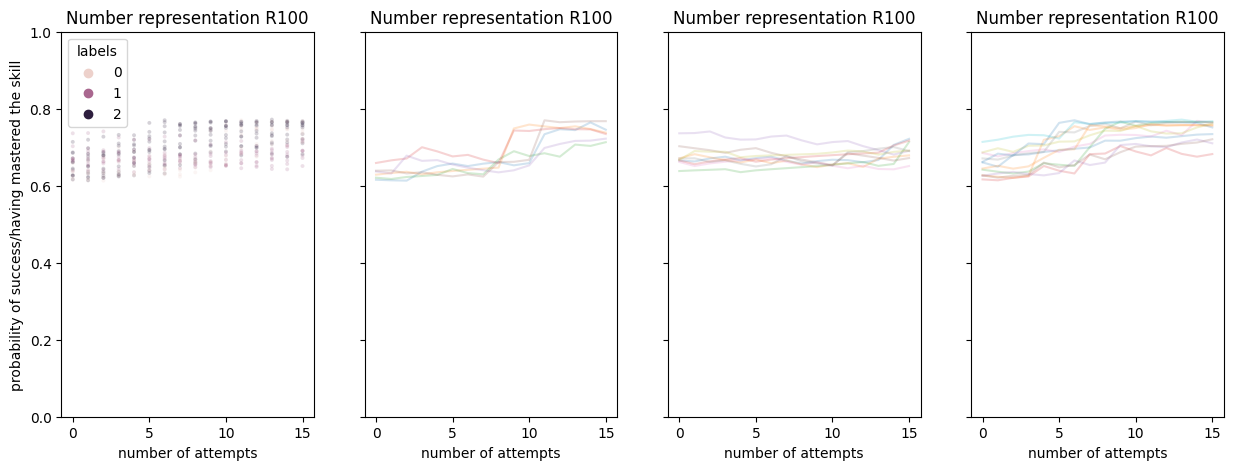

28

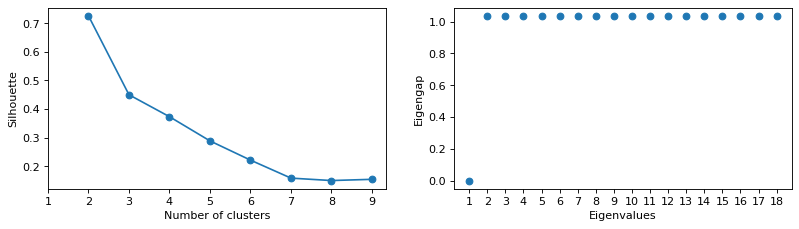

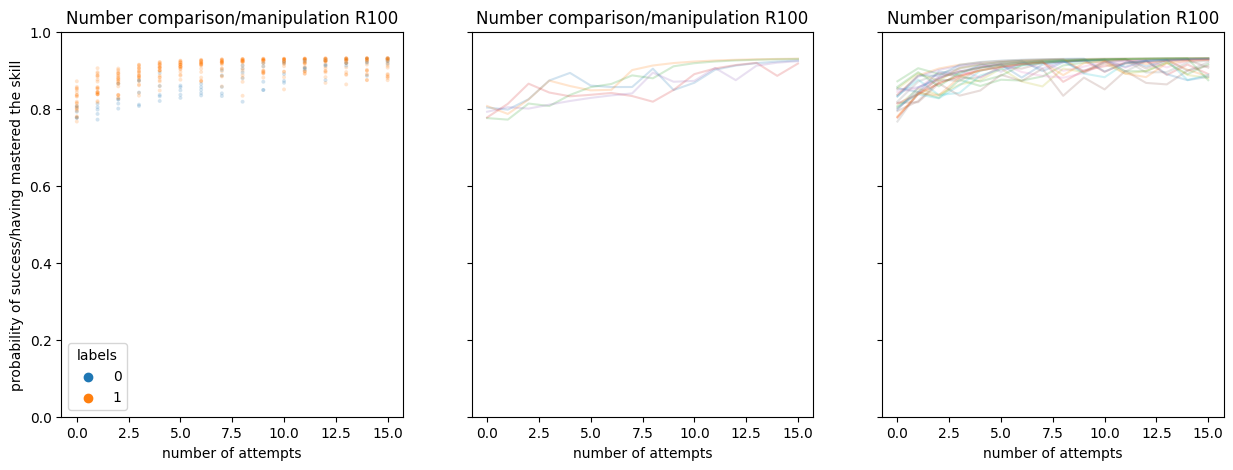

18

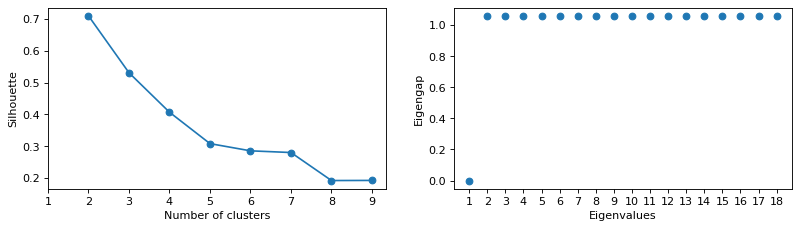

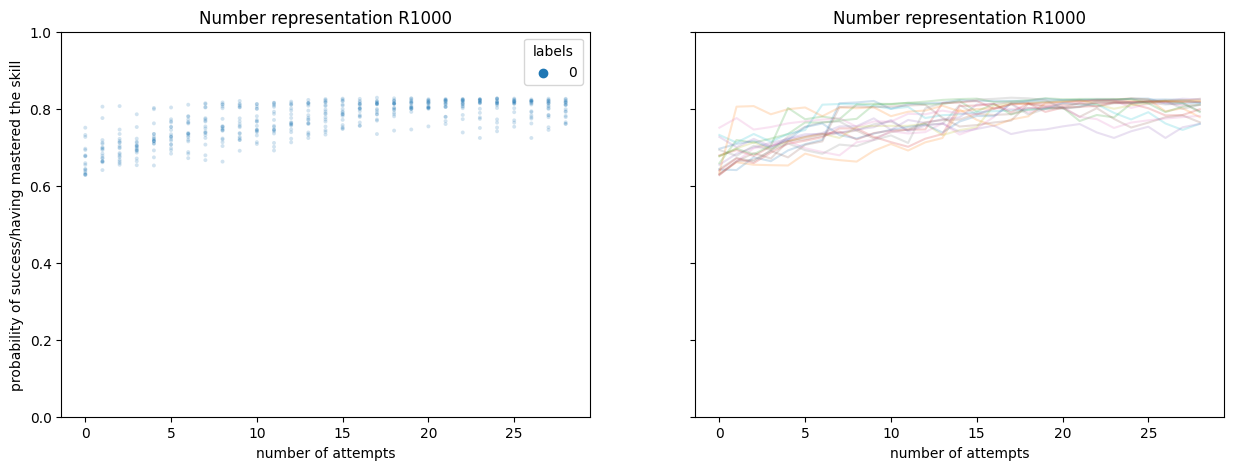

19

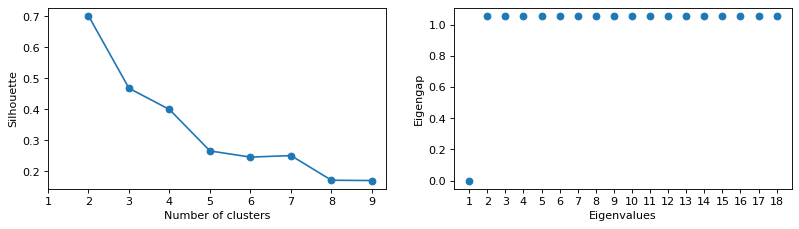

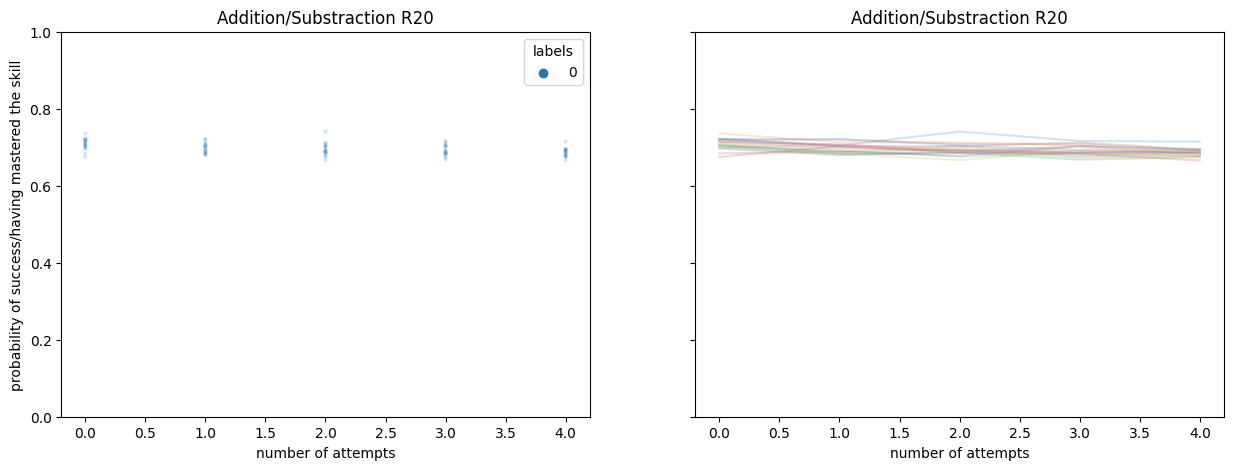

,subtask_id,user_id,skill_name,correct_predictions,attempt,labels
0,4009,63,Addition/Substraction R20,0.722575,0,0
1,4010,63,Addition/Substraction R20,0.704780,1,0
2,4016,63,Addition/Substraction R20,0.740730,2,0
3,4017,63,Addition/Substraction R20,0.716083,3,0
4,4018,63,Addition/Substraction R20,0.714410,4,0
...,...,...,...,...,...,...
90,54149,986,Addition/Substraction R20,0.709732,0,0
91,54184,986,Addition/Substraction R20,0.683697,1,0
92,54185,986,Addition/Substraction R20,0.666284,2,0
93,54199,986,Addition/Substraction R20,0.692139,3,0


In [27]:
w=0
for skill in skills :
    proba_dataset[skill] = clustering_vizualisation(skill,proba_dataset,nb_clusters[skill],w)
display(proba_dataset[skill])

# Fit the exponential function on every skill on every label

In [28]:
def exp_model(x, a, b, lambda_):
    return a - b*np.exp(-lambda_*x)

def exp_fit(x):
    param_pred, _ = scipy.optimize.curve_fit(lambda t,a,b,lambda_: a-b*np.exp(-lambda_*t),  x.attempt,  x.correct_predictions, bounds=([0,-1,0], [1, 1, np.inf]))
    a, b, lambda_ = param_pred
    return pd.Series([a, b, lambda_], index=['a', 'b', 'lambda_'])

In [29]:
# Compute the parameters for the exponential fit for each student
import warnings
with warnings.catch_warnings():
    warnings.simplefilter('ignore')

students_param = {}

for skill in skills :
    students_param[skill] = {}
    for label in (range(nb_clusters[skill])):
        students_param[skill][str(label)] = proba_dataset[skill][proba_dataset[skill]['labels']==label].groupby('user_id').apply(lambda x: exp_fit(x))
        students_param[skill][str(label)]['number_attempts'] = proba_dataset[skill][proba_dataset[skill]['labels']==label].groupby('user_id').size()

In [30]:
students_param[skill]['0']

,a,b,lambda_,number_attempts
user_id,,,,
63,7.198089e-01,0.000256,0.769127,5
109,6.593611e-01,-0.051753,0.246668,5
247,6.692339e-01,-0.029183,0.595959,5
270,6.700439e-01,-0.045450,0.298232,5
285,2.952437e-13,-0.722399,0.008985,5
305,7.028472e-01,-0.018012,18.294870,5
359,2.643359e-11,-0.703727,0.006636,5
399,6.955222e-01,-0.022238,1.531215,5
428,1.679255e-10,-0.703336,0.009052,5


In [31]:
"""for label in (range(nb_groups)) :
    print(label)
    pd.DataFrame(students_param[str(label)]).hist()
    display(pd.DataFrame(students_param[str(label)]).describe())"""

'for label in (range(nb_groups)) :\n    print(label)\n    pd.DataFrame(students_param[str(label)]).hist()\n    display(pd.DataFrame(students_param[str(label)]).describe())'

In [32]:
# Extract the median value of each parameter for each label
parameters = ['lambda_', 'a', 'b']
median_param = {}

for skill in skills :
    median_param[skill] = {}
    for label in (range(nb_clusters[skill])):
        median_param[skill][str(label)] = students_param[skill][str(label)][parameters].median()

pd.options.display.max_colwidth =100
print('The median values of the parameters for each skill are:')
median_param = pd.DataFrame(median_param)
display(median_param)


The median values of the parameters for each skill are:


,Number representation R10,Number comparison/manipulation R20,Number representation R20,Number comparison/manipulation R10,Number representation R100,Number comparison/manipulation R100,Number representation R1000,Addition/Substraction R20
0,lambda_ 0.391740 a 0.662968 b 0.101232 dtype: float64,lambda_ 0.344327 a 0.910292 b 0.042084 dtype: float64,lambda_ 0.070901 a 0.788966 b 0.086848 dtype: float64,lambda_ 0.454925 a 0.899599 b 0.315829 dtype: float64,lambda_ 0.026063 a 1.000000 b 0.396391 dtype: float64,lambda_ 0.069666 a 0.981708 b 0.202133 dtype: float64,lambda_ 0.112310 a 0.826209 b 0.176217 dtype: float64,lambda_ 0.595959 a 0.680003 b -0.025536 dtype: float64
1,NaN,lambda_ 0.467990 a 0.907184 b 0.137085 dtype: float64,lambda_ 0.470558 a 0.778799 b 0.191405 dtype: float64,lambda_ 0.550142 a 0.871554 b 0.047324 dtype: float64,lambda_ 0.007828 a 0.684511 b 0.017428 dtype: float64,lambda_ 0.397501 a 0.919525 b 0.104866 dtype: float64,NaN,NaN
2,NaN,NaN,NaN,NaN,lambda_ 0.100726 a 0.785832 b 0.155685 dtype: float64,NaN,NaN,NaN


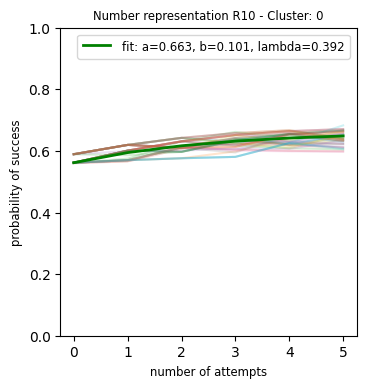

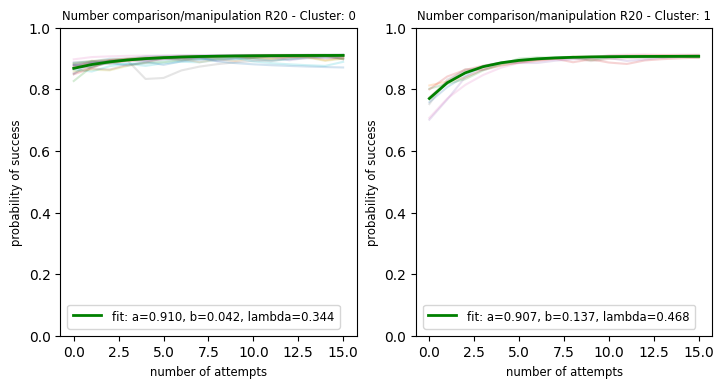

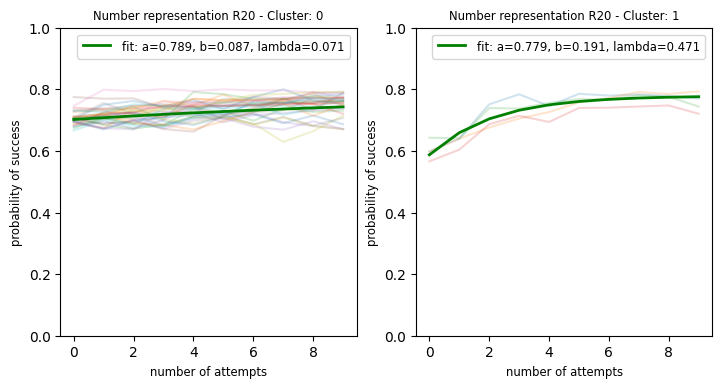

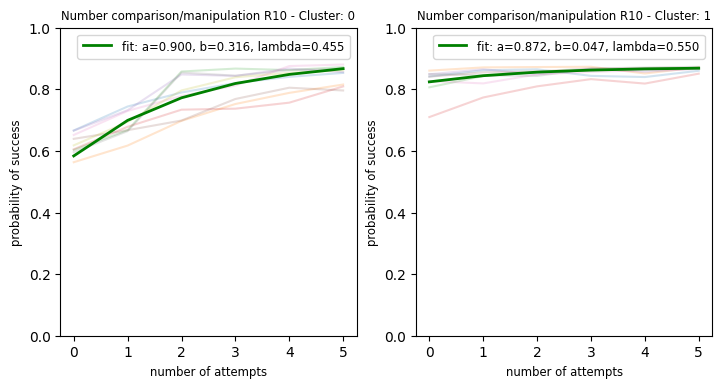

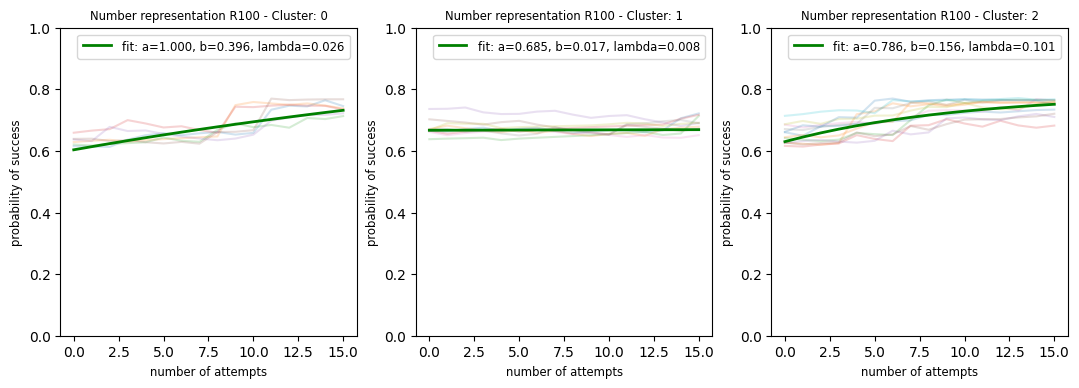

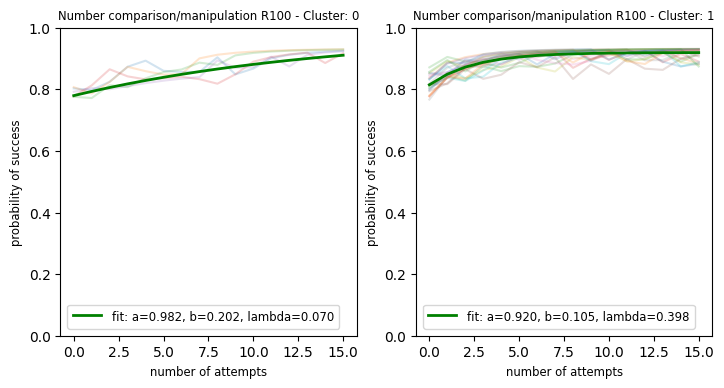

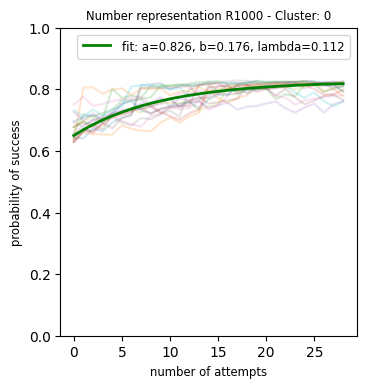

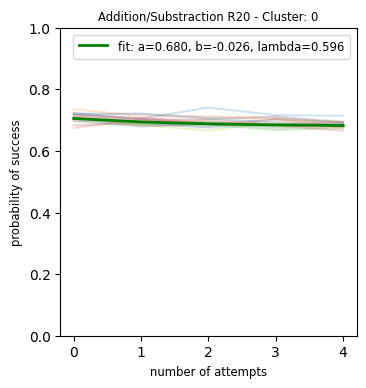

In [33]:
for skill in skills :
    #fig, ax = plt.subplots(1, nb_clusters[skill], figsize=(4*nb_clusters[skill], 4), constrained_layout=True, squeeze=False)
    n = nb_clusters[skill]
    fig = plt.figure(figsize=(13, 4))
    rx = np.arange(students_param[skill]['0'].number_attempts.iloc[0])
    for label in (range(nb_clusters[skill])):
        a_pred, b_pred, lambda_pred = median_param[skill][str(label)].a, median_param[skill][str(label)].b, median_param[skill][str(label)].lambda_

        df = proba_dataset[skill][proba_dataset[skill]['labels']==label]
        grouped_df = df.groupby('user_id')
        #ax = ax.flatten()
        ax = plt.subplot2grid((1, 3), (0, label))
        for user_id, group in grouped_df:
            sns.lineplot(data=group, x='attempt', y='correct_predictions', alpha=0.2, ax=ax)

        #ax[label].scatter(proba_dataset[skill].attempt, proba_dataset[skill].correct_predictions, label='data', alpha=0.2, s=8)
        ax.plot(rx, exp_model(rx, a_pred, b_pred, lambda_pred), label='fit: a=%5.3f, b=%5.3f, lambda=%5.3f' % tuple([a_pred, b_pred, lambda_pred]), color='green', linewidth=2)
        ax.set_xlabel('number of attempts', fontsize = 'small')
        ax.set_ylabel('probability of success', fontsize = 'small')
        ax.set_title('{} - Cluster: {}'.format(skill, label), fontdict = {'fontsize': 'small'})
        ax.set_ylim(0, 1)
        ax.legend()
        ax.get_legend().get_texts()[0].set_fontsize('small')
    #plt.suptitle('Exponential fit for each cluster of {}'.format(skill), size ='small')
    plt.show()